# DESCQA-SRV gaap

Owners: **PatriciaLarsen [@plarsen](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@patricialarsen)**  
Last Verifed to Run: **2024-06-04** (by @plarsen)

This notebook details the DESCQA-SRV gaap test. This test can be run on the command line for the full dp0.2 catalog using 

```bash
 ./run_master.sh -t srv_gaap -c dp02
```

First let's load the catalog and then get started! We're doing a single tract catalog to go through code explanations, and then we'll point to the results of a full run.


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.colors as mcolors
import math
import time
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs-test')
import GCRCatalogs
from utils import *

catalog = GCRCatalogs.load_catalog('lsst_object')
%matplotlib inline

## Gaussian Aperture (GAaP) flux measurements 

The Guassian aperture method was developed by [Kuijken 2008](https://www.aanda.org/articles/aa/full/2008/18/aa6601-06/aa6601-06.html) to more accurately measure colors in the presence of different seeing conditions. It emphasizes consistency between different bands, by computing the flux that would be measured with a Gaussian PSF. This typically measures the flux emanating from the centers of galaxies, and therefore isn't designed to be an accurate measurement of the total galaxy flux. 

### Project testing 
This test is the only one I see that includes gaap fluxes in the core tests, but please note that if you want more GAaP checks in the project tests, it is easy to alter tests based on other flux measurements and I'm sure the project would be happy for someone to go in and make these.
- SkyObject plots include GAaP 1.0 aperture S/N and flux 

### This test

This test centers around sanity checks of the gaap measurements: we look at the performance of the optimal aperture vs the different aperture sizes, the signal-to-noise of the flux measurements and the number of galaxies above an SNR of 5, then we inspect the colors as a function of these apertures. Finally we look for stellar contamination through an unresolved source check. 


## Optimal aperture signal-to-noise ratio 

In this test we look at the optimal aperture measurements. To do this we plot the median SNR vs aperture width curve for each band, overplotting the SNR of the optimal elliptical aperture. This plots the total number of galaxies above a SNR threshold, the median SNR of those galaxies, and the sum of the SNR values. You expect the optimal aperture to do well compared to the circular apertures for these metrics, and the total SNR to be above or at that of the circular apertures. 

First we need to quickly read in the data, we'll cut on the extendedness flag to restrict ourselves to galaxies, and on detect_isPrimary, and read in the gaap flags and fluxes. 

In [33]:
# read necessary quantities 
quantities = ["coord_ra","coord_dec"]
bands = ["r","i","z","g","y"]
aps=['0p5','0p7','1p0','1p5','2p5','3p0','Optimal','Psf']
aps_reduced = ['0p5','0p7','1p0','1p5','2p5','3p0','Optimal']

for band in bands:
    for ap in aps:
        quantities.append(band+"_gaap" + ap+ "Flux")
        quantities.append(band+"_gaap" + ap+ "FluxErr")
    for ap in aps_reduced:
        quantities.append(band+"_gaap" + ap+ "Flux_flag_bigPsf")
    quantities.append(band+"_gaapFlux_flag")
    quantities.append(band+"_gaapFlux_flag_edge")
    quantities.append(band+"_gaapFlux_flag_gaussianization")
            
filters = ["detect_isPrimary"]
for band in bands:
    filters.append(band+"_extendedness==1")
    filters.append(band+"_extendedness_flag==False")
data = catalog.get_quantities(quantities, filters=filters)  

ra = data['coord_ra']
dec = data['coord_dec']
for band in bands:
    for ap in aps:
        data['snr_'+band+'_'+ap] = data[band+'_gaap'+ap+'Flux']/data[band+'_gaap'+ap+'FluxErr']
        data['mag_'+band+'_'+ap] = convert_nanoJansky_to_mag(data[band+'_gaap'+ap+'Flux'])

        
        


/tmp/ipykernel_851197/1112940333.py:27: RuntimeWarning: invalid value encountered in divide
  data['snr_'+band+'_'+ap] = data[band+'_gaap'+ap+'Flux']/data[band+'_gaap'+ap+'FluxErr']


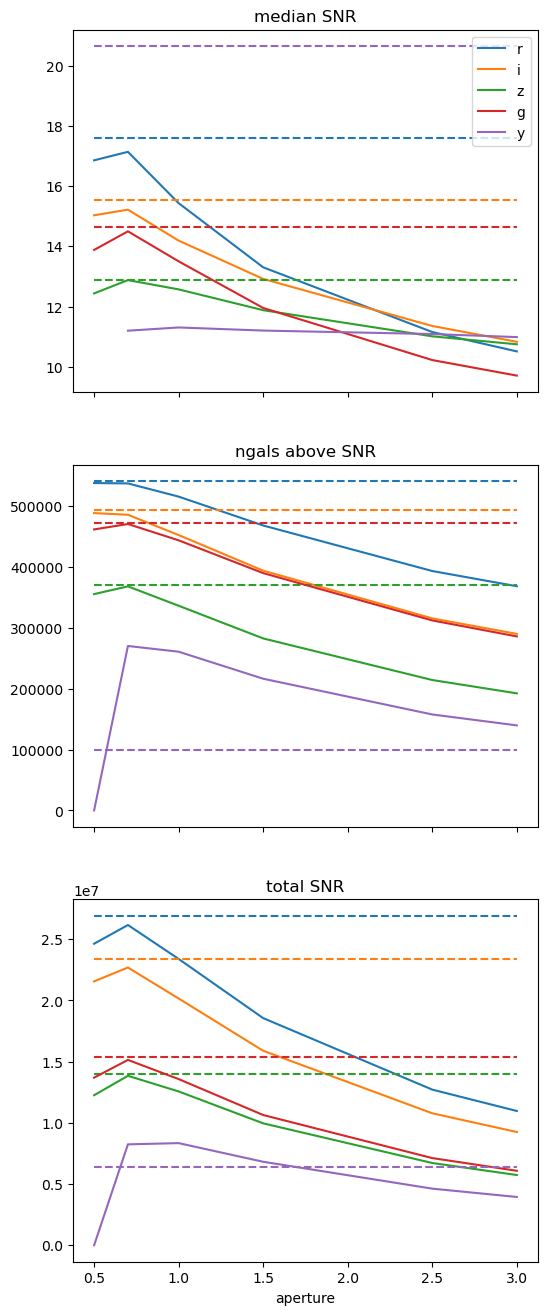

In [34]:
snr_lim = 5 

fig= plt.figure(figsize = (6,16))
plt.subplot(311)
plt.title('median SNR')
plt.subplot(312)
plt.title('ngals above SNR')
plt.subplot(313)
plt.title('total SNR')
clist = list(mcolors.TABLEAU_COLORS.keys())
ap_list = [0.5,0.7,1.0,1.5,2.5,3.0]

i = 0 
for band in bands:
    n_ap=[]
    snr_ap=[]
    snr_tot=[]
    for ap in aps_reduced[:-1]:
        mask_ap = (data[band+'_gaapFlux_flag']==False)&(data['snr_'+band+'_'+ap]>=snr_lim)
        snr = data['snr_'+band+'_'+ap][mask_ap]
        n_ap.append(len(snr))
        snr_ap.append(np.median(snr))
        snr_tot.append(np.sum(snr))
    plt.subplot(311)
    plt.plot(ap_list,snr_ap,label=band, c=clist[i])
    mask_optimal = (data[band+'_gaapFlux_flag']==False)&(data['snr_'+band+'_Optimal']>=snr_lim)
    snr_optimal = data['snr_'+band+'_Optimal'][mask_optimal]
    plt.plot(ap_list,np.median(snr_optimal)*np.ones(len(snr_ap)),'--', c=clist[i])
    plt.subplot(312)
    plt.plot(ap_list,n_ap,label=band, c = clist[i])
    plt.plot(ap_list,len(snr_optimal)*np.ones(len(snr_ap)),'--', c = clist[i])
    plt.subplot(313)
    plt.plot(ap_list,snr_tot,label=band, c=clist[i])
    plt.plot(ap_list,np.sum(snr_optimal)*np.ones(len(snr_ap)),'--', c=clist[i])
    i += 1
plt.xlabel('aperture')
plt.subplot(311)
plt.legend(loc = 'upper right')
for ax in fig.get_axes():
    ax.label_outer()


Here the dashed horizontal lines are the optimal aperture, and the solid lines are the bands as a function of the aperture width. You can see that the optimal aperture is pretty similar to the 0.7 or 1.0 pixel width apertures. This gives a good median SNR and number of galaxies above the SNR, except in the case of the y-band where we see a high rate of failures in the optimal aperture method as evidenced by the number of galaxies above the signal-to-noise limit and the total signal-to-noise being lower in the optimal aperture than the 0.7 or 1.0 apertures.

## Test 2 - optimal vs circular aperture colors

We compare g-i color in circular apertures to that of the optimal aperture. You expect this to match at around the peak of the SNR curve in the above function, and diverge at large apertures where the outskirts of the galaxy contribute to the color. You see this by a wider range of values for the 0.5 and 2.5, 3.0 aperture widths and a tighter relation for the rest. 

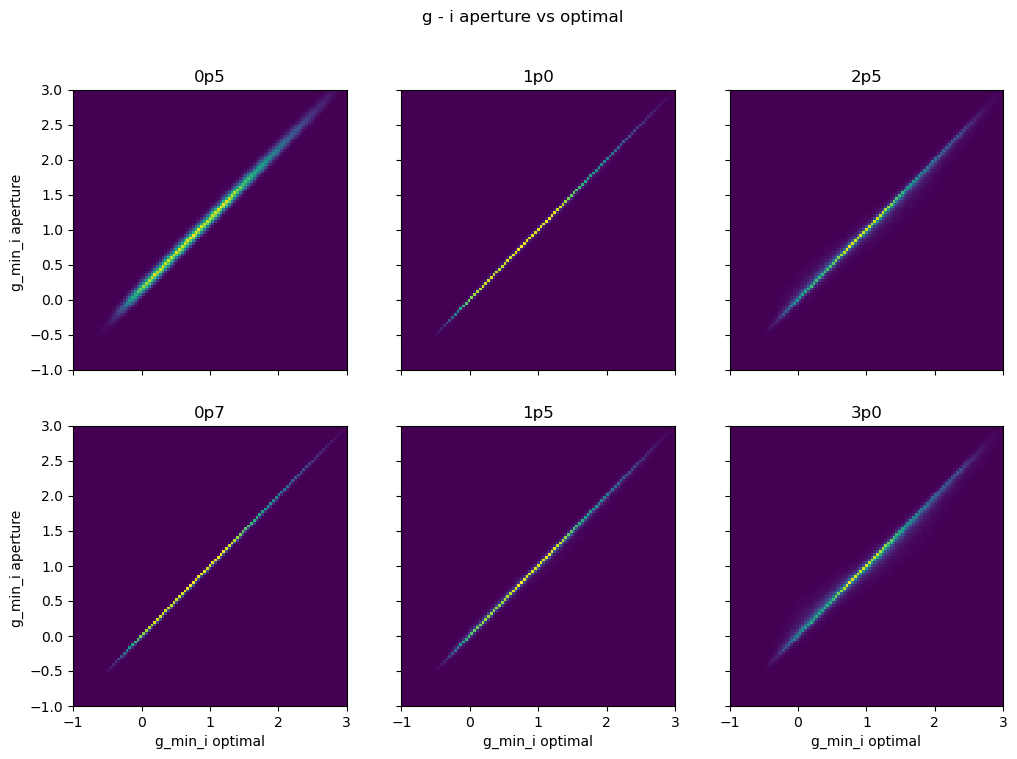

In [35]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
fig.suptitle('g - i aperture vs optimal')
count_plot = 0 

for ap in aps_reduced[:-1]:
    idx1 = count_plot%2
    idx2 = math.floor(count_plot/2)      
    mask_ap = (data['snr_g_'+ap]>=snr_lim)& (data['snr_i_'+ap]>=snr_lim)&(data['snr_g_Optimal']>=snr_lim)&(data['snr_i_Optimal']>=snr_lim) # passes SNR lim in both
    g_min_i = data['mag_g_'+ap][mask_ap] - data['mag_i_'+ap][mask_ap]
    g_min_i_opt =  data['mag_g_Optimal'][mask_ap] - data['mag_i_Optimal'][mask_ap]
    axs[idx1,idx2].hist2d(g_min_i_opt,g_min_i,bins=np.linspace(-1,3,100))
    axs[idx1,idx2].set_title(ap)
    axs[idx1,idx2].set_xlabel('g_min_i optimal')
    axs[idx1,idx2].set_ylabel('g_min_i aperture ')
    count_plot +=1 

for ax in fig.get_axes():
    ax.label_outer()

plt.show()


## Test 3 color-color plot

Compare r-i / g-r color-color plot for different circular apertures and the optimal aperture. You expect to see for DC2 a wishbone-type image with distinct populations. At larger apertures this may get blurred as the signal to noise decreases. 

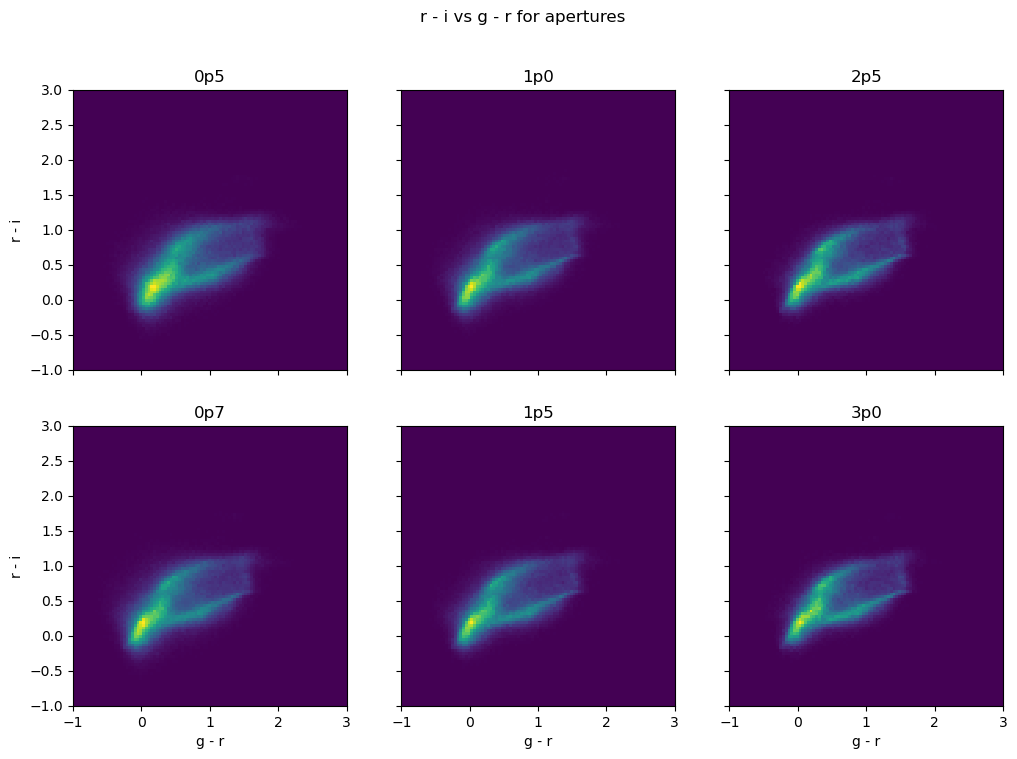

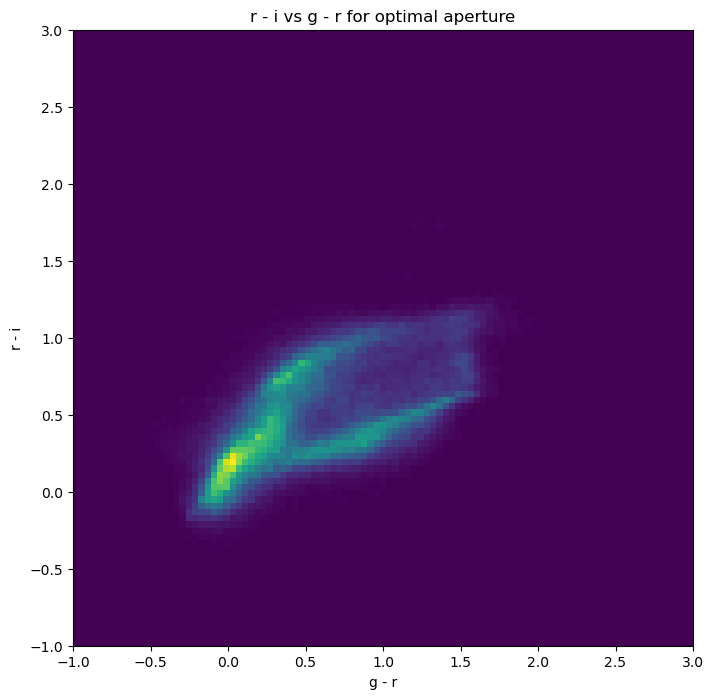

In [36]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
fig.suptitle('r - i vs g - r for apertures')
count_plot = 0
for ap in aps_reduced[:-1]:
    idx1 = count_plot%2
    idx2 = math.floor(count_plot/2)
    
    mask_ap = (data['snr_g_'+ap]>=snr_lim)& (data['snr_i_'+ap]>=snr_lim) &(data['snr_r_'+ap]>=snr_lim)  &(data['snr_g_Optimal']>=snr_lim)&(data['snr_i_Optimal']>=snr_lim)&(data['snr_r_Optimal']>=snr_lim)  # passes SNR lim in both
    g_min_r = data['mag_g_'+ap][mask_ap] - data['mag_r_'+ap][mask_ap]
    g_min_r_opt =  data['mag_g_Optimal'][mask_ap] - data['mag_r_Optimal'][mask_ap]
    r_min_i = data['mag_r_'+ap][mask_ap] - data['mag_i_'+ap][mask_ap]
    r_min_i_opt =  data['mag_r_Optimal'][mask_ap] - data['mag_i_Optimal'][mask_ap]

    axs[idx1,idx2].hist2d(g_min_r,r_min_i,bins=np.linspace(-1,3,100))
    axs[idx1,idx2].set_title(ap)
    axs[idx1,idx2].set_xlabel('g - r' )
    axs[idx1,idx2].set_ylabel('r - i')
    count_plot +=1 

for ax in fig.get_axes():
    ax.label_outer()
plt.show()

plt.figure(figsize=(8,8))
plt.hist2d(g_min_r_opt,r_min_i_opt,bins=np.linspace(-1,3,100))
plt.title('r - i vs g - r for optimal aperture')
plt.xlabel('g - r' )
plt.ylabel('r - i')
plt.show()

## Test 4 - unresolved sources 
Plotting unresolved sources, i.e. ones where the lowest apertures detect the same total magnitude. This suggests stellar contamination in the sample. 

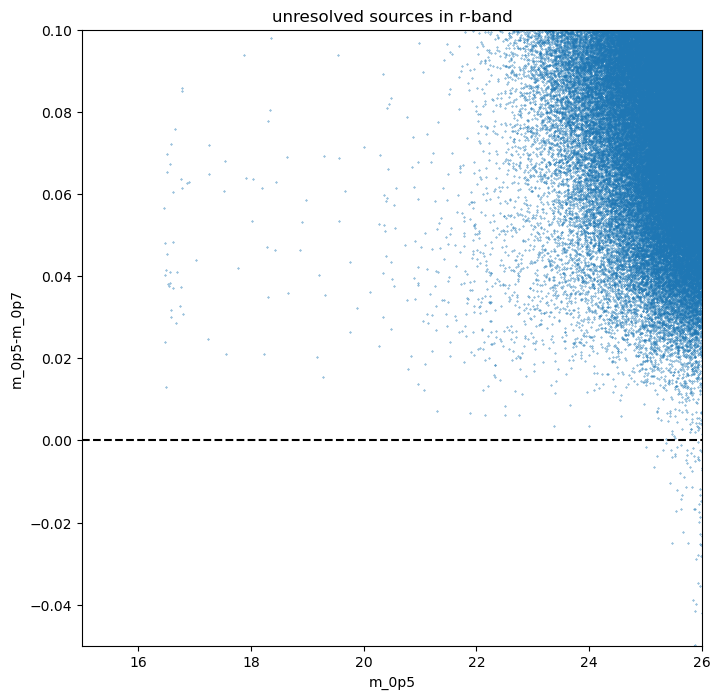

In [37]:
mag_r_ap05 = data['mag_r_0p5']
mag_r_ap07 = data['mag_r_0p7']

plt.figure(figsize = (8,8))
plt.title('unresolved sources in r-band')
plt.plot(np.linspace(15,26,100),np.zeros(100),'k--')
plt.scatter(mag_r_ap05,mag_r_ap05-mag_r_ap07,s=0.1)
plt.xlim([15,26])
plt.ylim([-0.05,0.1])
plt.xlabel('m_0p5')
plt.ylabel('m_0p5-m_0p7')
plt.show()

We see very little evidence of stellar contamination, which would show as a population at the horizontal dashed line. 

## Metrics and Updates


### DESC SRD requirements



### How to improve these results




## Notebook updates
